In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression

path = 'inputs/'

In [6]:
def lag_feature(df, feat, lags=[1], suf='_lag', drop=True):
    for lag in lags:
        df[f'{feat}{suf}{lag}'] = df[feat].shift(lag)
    if drop:
        df = df.drop(columns=[feat])
    return df



In [8]:
df_store = pd.read_csv(path + 'stores.csv',
                         usecols=['store_nbr', 'city', 'state', 'type', 'cluster'],
                         dtype={'store_nbr': 'category', 'city': 'category', 'state': 'category', 'cluster': 'category'})

df_trans = pd.read_csv(path + 'transactions.csv',
                       usecols=['store_nbr', 'date', 'transactions'],
                       dtype={'store_nbr': 'category', 'transactions': 'float32'},
                       parse_dates=['date'],
                       date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d').to_period('D'),
                       infer_datetime_format=True)

df_holiday = pd.read_csv(path + 'holidays_events.csv',
                         index_col=['date'],
                         usecols=['date', 'type', 'locale', 'locale_name', 'transferred'],
                         dtype={'type' : 'str', 'locale_name': 'str', 'locale': 'str', 'transferred': 'boolean'},
                         parse_dates=['date'],
                         date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d').to_period('D'),
                         infer_datetime_format=True)

df_oil = pd.read_csv(path + 'oil.csv',
                     index_col=['date'],
                     parse_dates=['date'],
                     date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d').to_period('D'),
                     infer_datetime_format=True)

df_train = pd.read_csv(path + 'train.csv',
                       usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
                       index_col=['date', 'store_nbr', 'family'],
                       dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32', 'onpromotion': 'uint32'},
                       parse_dates=['date'],
                       date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d').to_period('D'),
                       infer_datetime_format=True)

train_easy = pd.read_csv(path + 'train.csv',
                       usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
                       dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32', 'onpromotion': 'uint32'},
                       parse_dates=['date'],
                       date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d').to_period('D'),
                       infer_datetime_format=True)

df_test = pd.read_csv(path + 'test.csv',
                      usecols=['store_nbr', 'family', 'date', 'onpromotion'],
                      index_col=['date', 'store_nbr', 'family'],
                      dtype={'store_nbr': 'category', 'family': 'category', 'onpromotion': 'uint32'},
                      parse_dates=['date'],
                      date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d').to_period('D'),
                      infer_datetime_format=True)

df_data = {
    'trsimp': train_easy,
    'holiday_load': df_holiday,
    'oil_load': df_oil,
    'train_load': df_train,
    'test_load': df_test,
    'store_load': df_store,
    'trans_load': df_trans,
}

In [9]:
stores = df_data['store_load'].copy()
uniq = stores.city.value_counts()[stores.city.value_counts() == 1].index.tolist()
stores['uniq_store'] = stores.city.apply(lambda x: 1 if x in uniq else 0)
###WHY
new_stores = [19, 20, 21, 28, 35, 41, 51, 52]
stores['new_store'] = stores['store_nbr'].apply(lambda x: 1 if x in new_stores else 0)
stores = stores.rename(columns={'type': 'store'})
stores = stores.set_index('store_nbr')
df_data['str_mod'] = stores

In [10]:
oil = df_data['oil_load'].copy()
oil = oil.resample('D').mean().interpolate(limit_direction='backward').reset_index()
oil = lag_feature(oil, 'dcoilwtico', [1, 2, 3, 4], drop=False)
oil['wk_avg_oil'] = oil['dcoilwtico'].rolling(7).mean()
oil['biwk_avg_oil'] = oil['dcoilwtico'].rolling(14).mean()
oil['mnth_avg_oil'] = oil['dcoilwtico'].rolling(30).mean()
oil['bimnth_avg_oil'] = oil['dcoilwtico'].rolling(60).mean()
oil.dropna(inplace=True)
oil = oil.set_index('date')
df_data['oil_mod'] = oil

In [11]:
date_range = pd.Series(pd.date_range('2013-01-01', '2017-08-31').to_period('D'), name='date')
cal = pd.DataFrame(index=date_range)
cal = cal.merge(df_data['holiday_load'], how='left', on=['date'])
cal.loc[cal.isna().any(axis=1),
           ['type', 'locale', 'locale_name', 'transferred']] = 'Work Day', 'National', 'Ecuador', False
cal['wd'] = True
cal.loc[(cal.type == 'Bridge') | (cal.type == 'Transfer'), 'wd'] = False

cal.loc[(((cal.type == 'Additional')|(cal.type == 'Holiday')) & (cal.transferred == False)), 'wd'] = False
easter = ['2017-04-16', '2016-03-27', '2015-04-05', '2014-04-20', '2013-03-31']
easter = [pd.to_datetime(date, format='%Y-%m-%d').to_period('D') for date in easter]
cal['isevnt'] = False
cal.loc[cal.index.get_level_values('date').isin(easter), 'isevnt'] = True
cal = pd.get_dummies(cal, columns=['type'])
cal = pd.get_dummies(cal, columns=['locale'])
cal.drop(columns=['locale_name', 'transferred'], inplace=True)
agg=lambda x: np.bitwise_or.reduce(x.values)
cal = cal.groupby('date').agg(agg)
df_data['cal'] = cal

In [12]:
train_df = df_data['train_load'].copy()
test_df = df_data['test_load'].copy()
test_df.sales = np.nan

df = pd.concat([train_df, test_df], axis=0)
df = df.merge(df_data['str_mod'], how='left', left_index=True, right_index=True)
df.drop(df.filter(regex='_y$').columns, axis=1, inplace=True)
df['closed'] = df.groupby(by=['date', 'store_nbr'])['sales'].transform(lambda x:1 if x.sum() ==0 else 0)
# stores in test set aren't close, just have 0 sales
df.loc[
    ((df.index.get_level_values('date').year==2017) &
     (df.index.get_level_values('date').month==8) & (
             df.index.get_level_values('date').day>=16)) , 'closed'] = df['closed'].apply(lambda x: 0)

## Holidays
df = df.merge(df_data['cal'], how='left', left_index=True, right_index=True, suffixes=('', '_y'))
df.drop(df.filter(regex='_y$').columns, axis=1, inplace=True)

In [13]:
## Oil
df = df.merge(df_data['oil_mod'], how='left', left_index=True, right_index=True)

In [14]:
df['year'] = df.index.get_level_values('date').year.astype('int')
df['quarter'] = df.index.get_level_values('date').quarter.astype('int')
df['day'] = df.index.get_level_values('date').day.astype('int')

df['weekofyear'] = df.index.get_level_values('date').week.astype('int')
df['dayofweek'] = df.index.get_level_values('date').day_of_week.astype('int')
df['isweekend'] = df.dayofweek.apply(lambda x: 1 if x in (5,6) else 0)

df['newyear'] = df.index.get_level_values('date').dayofyear == 1
df['startschool'] = df.index.get_level_values('date').month.isin((4,5,8,9))
df['weekend'] = df.index.get_level_values('date').dayofweek.isin((5,6))

In [15]:
df['payday'] = ((df.index.get_level_values('date').to_timestamp().is_month_end) | (df.index.get_level_values('date').day == 15))

quake_dates = [d.to_period('D') for d in pd.date_range('2016-04-16', periods=20, freq='D').tolist()]
df['quake'] = df.index.get_level_values('date').isin(quake_dates)

In [16]:
df = pd.get_dummies(df, columns=['year'], drop_first=True)
df = pd.get_dummies(df, columns=['quarter'], drop_first=True)
df = pd.get_dummies(df, columns=['dayofweek'], drop_first=True)

df['wk_avg_promo'] = df['onpromotion'].rolling(7).mean()
df['biwk_avh_promo'] = df['onpromotion'].rolling(14).mean()
df['mnth_avg_promo'] = df['onpromotion'].rolling(30).mean()
df['bimnth_avg_promo'] = df['onpromotion'].rolling(60).mean()

df.drop(columns=['city', 'cluster', 'state', 'store'], inplace=True)

In [18]:
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 37.9 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 kB 46.5 MB/s eta 0:00:00


In [19]:
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import CalendarFourier

fourier_annual = CalendarFourier(freq='A', order=5)
fourier_monthly = CalendarFourier(freq='M', order=2)
fourier_weekly = CalendarFourier(freq='W', order=3)

terms = [fourier_annual, fourier_monthly, fourier_weekly]

dp = DeterministicProcess(index=df.index.get_level_values('date'),
                          order=1,
                          seasonal=True,
                          constant=False,
                          additional_terms=terms,
                          drop=True)

df_dp = dp.in_sample()
df = pd.concat([df.reset_index(level=['store_nbr', 'family']), df_dp], axis=1)

df = df.set_index(['store_nbr', 'family'], append=True)

In [20]:
with open(path + 'featured_datafram.pkl', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
import time
from datetime import datetime
from tqdm.notebook import tqdm
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_log_error
from IPython.core import display as ICD
from upgini import FeaturesEnricher, SearchKey, ModelTaskType
from upgini.metadata import CVType

def _scorer(y_true, y_predicted):
    y_true = np.exp(y_true)-1
    y_predicted = np.exp(y_predicted)-1
    return mean_squared_log_error(y_true, y_predicted, squared=False)

scorer = make_scorer(_scorer, greater_is_better=False)

def index_timeseries_train_test_split(df, date_index=False, date_format='%Y-%m-%d', earliest_train_date=None, split_date=None, last_test_date=None, verbose=True):
    dates = df.index.get_level_values('date').to_timestamp()

    if earliest_train_date:
        earliest_train_datetime = datetime.strptime(earliest_train_date, date_format)
        df = df.loc[[earliest_train_datetime<=date for date in dates]]
        dates = df.index.get_level_values('date').to_timestamp()

    if last_test_date:
        last_test_datetime = datetime.strptime(last_test_date, date_format)
        df = df.loc[[date<last_test_datetime for date in dates]]
        dates = df.index.get_level_values('date').to_timestamp()

    split_datetime = datetime.strptime(split_date, date_format)
    train_dates = [date<split_datetime for date in dates]
    test_dates = np.invert(train_dates)

    train_df = df.loc[train_dates]
    test_df =  df.loc[test_dates]

    if verbose:
        print('================================')
        print('Training Dataset last rows')
        ICD.display(train_df.tail(3))
        print('================================')
        print('Test Dataset first rows')
        ICD.display(test_df.head(3))

    return train_df, test_df


def separate_X_and_y(df, target='sales'):
    y = df[target].values
    X = df.drop(columns=target)
    return X, y


def unstack_transformation(X, y, group_by='date', target='sales', levels=['store_nbr', 'family']):
    df = X.copy()
    df[target] = y
    y = df.loc[:, target].unstack(levels)
    X = df.drop(columns=[target]).groupby(by=group_by).first()
    return X, y


def create_sample_weights(X, target_date, weight=0.9):
    extra_weight_days = X.index.get_level_values('date') > target_date
    return np.array(list(map(lambda x: np.exp(-weight) if x == 0 else 1, extra_weight_days.astype('int'))))


def get_closed_stores(df, last_days=15):
    closed_stores_df = df.groupby(['family']).tail(last_days).groupby(['family'])['sales'].sum().reset_index()
    closed_stores_df = closed_stores_df[closed_stores_df['sales'] == 0].drop('sales', axis = 1)
    closed_stores_df = closed_stores_df[closed_stores_df['family'] != "SCHOOL AND OFFICE SUPPLIES"]
    closed_stores_df = closed_stores_df.set_index(['family'])
    closed_stores_df['closed'] = True
    return closed_stores_df


def apply_zero_forecasting(df, closed_stores_df):
    df = df.merge(closed_stores_df, how='left',  left_index=True, right_index=True)
    df.loc[df['closed']==True, 'sales']=0
    df.drop(columns=['closed'], inplace=True)
    return df


def timeit(function):
    def wrapper(*args, **kwargs):
        ts = time.perf_counter()
        func = function(*args, **kwargs)
        te = time.perf_counter ()
        run_time = time.perf_counter() - ts
        print(f'Run Time: {run_time} secs')
        return func
    return wrapper


def plot_feature_importance(feature_importances, feature_names):
    feats = {} # a dict to hold feature_name: feature_importance
    for feature, importance in zip(feature_names, feature_importances):
        feats[feature] = importance #add the name/value pair

    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
    importances.sort_values(by='Gini-importance').plot(kind='bar')



def plot_feature_elimination_score(min_features_to_select, grid_score):
    plt.figure()
    plt.xlabel('Number of features selected')
    plt.ylabel('Cross validation score')
    plt.plot(
        range(min_features_to_select, len(grid_score) + min_features_to_select),
        grid_score
    )
    plt.show()


def plot_predition_timeseries(x, y_actual, y_pred):
    df = pd.DataFrame()
    df['date'], df['actual'], df['prediction'] = x, y_actual, y_pred
    df = df.groupby(['date'], as_index=False).sum().reset_index()
    df['date'] = df['date'].apply(lambda row: row.to_timestamp())
    title = 'Actual vs Prediction'
    df.plot.line(x='date', y=['actual', 'prediction'], title=title)


def transform_prediction_to_df(X, y, prediction):
    return pd.DataFrame(pd.DataFrame(prediction,
                        index=X.index,
                        columns=y.columns).stack(['store_nbr'])).rename(columns={0: 'sales'})


def per_family_df_generator(train_df, test_df, verbose=False):
    families = sorted(train_df.index.get_level_values('family').unique())
    for _, family in zip(tqdm(range(len(families))), families):
        if verbose:
            print('='*40)
            print(f'Family: {family}')
        # Train DF
        train_family_df = train_df[train_df.index.get_level_values('family')==family]
        train_family_df.index = train_family_df.index.droplevel('family')
        # Test DF
        test_family_df = test_df[test_df.index.get_level_values('family')==family]
        test_family_df.index = test_family_df.index.droplevel('family')
        yield family, train_family_df, test_family_df

In [22]:
class UpginiEnricher:
    def __init__(self):
        self.enricher = FeaturesEnricher(
        search_keys={
            "date": SearchKey.DATE
        },
        country_code = "EC",
        model_task_type = ModelTaskType.REGRESSION,
        cv = CVType.time_series,
        )

    def fit(self, df):
        df = df.reset_index()[['date','sales']].groupby('date', as_index=False).mean()
        y = df['sales'].values
        X = df.drop(columns=['sales'])

        self.enricher.fit(
            X,
            y,
            calculate_metrics=True,
            max_features=3)
        return self

    def transform(self, df):
        return self.enricher.transform(df.copy().reset_index(),
                                       keep_input=True,
                                       max_features=4,
                                    ).set_index(['date', 'store_nbr'])

In [23]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression


class MultiOutBaggingExtraTreesRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,
                extra_trees_n_estimators=200,
                bagging_n_estimators=10,
                log_target_transform=True,
                multioutput=True,
                n_jobs=-1,
                random_state=42):
        super().__init__()
        _r1 = ExtraTreesRegressor(n_estimators=extra_trees_n_estimators,
                                  n_jobs=n_jobs,
                                  random_state=random_state)
        _estimator = BaggingRegressor(base_estimator=_r1,
                                      n_estimators=bagging_n_estimators,
                                      bootstrap=True,
                                      n_jobs=n_jobs,
                                      random_state=random_state)
        if multioutput:
            _estimator = MultiOutputRegressor(_estimator)
        self.estimator_ = _estimator
        self.log_target_transform = log_target_transform
        self.feature_importances_ = None
        self.bagging_n_estimators = bagging_n_estimators
        self.extra_trees_n_estimators = extra_trees_n_estimators
        self.multioutput = multioutput
        self.n_jobs = n_jobs
        self.random_state = random_state

    def fit(self, X, y, sample_weight=None):
        if self.log_target_transform:
            y = np.log1p(y)
        self.estimator_.fit(X, y, sample_weight)

        if self.multioutput:
            feature_importances_ = []
            for n_output_estimators in self.estimator_.estimators_:
                feature_importances_.append(np.mean([
                tree.feature_importances_ for tree in n_output_estimators.estimators_], axis=0))
            self.feature_importances_ = np.mean(feature_importances_, axis=0)
        else:
            self.feature_importances_ = np.mean([
                tree.feature_importances_ for tree in self.estimator_.estimators_], axis=0)

        return self

    def predict(self, X, y=None):
        prediction = self.estimator_.predict(X)
        if self.log_target_transform:
            prediction = (np.exp(prediction)-1)
        return prediction.clip(0)

    def score(self, X, y):
        prediction = self.predict(X, y)
        return mean_squared_log_error(y, prediction, squared=False)

In [24]:
from sklearn.metrics import mean_squared_log_error

def family_prediction_generator(train_df, test_df, estimator_params={}, verbose=True):
    for family, train_family_df, test_family_df in per_family_df_generator(train_df, test_df, verbose=verbose):

        if family in ['LIQUOR,WINE,BEER', 'CLEANING']:
            enricher = UpginiEnricher()
            enricher.fit(train_family_df)
            train_family_df = enricher.transform(train_family_df)
            test_family_df = enricher.transform(test_family_df)

        # =====================================
        # Create multi-output (with unstack)
        # =====================================
        X_train, y_train = separate_X_and_y(train_family_df)
        X_train, y_train = unstack_transformation(X_train, y_train, levels=['store_nbr'])
        X_test, y_test = separate_X_and_y(test_family_df)
        X_test, y_test = unstack_transformation(X_test, y_test, levels=['store_nbr'])

        # =====================================
        # Train
        # =====================================
        no_multiple_outputs = ['BABY CARE', 'GROCERY II','HOME AND KITCHEN I','HOME AND KITCHEN II', 'SCHOOL AND OFFICE SUPPLIES']
        if family in no_multiple_outputs:
            estimator = MultiOutBaggingExtraTreesRegressor(**estimator_params, multioutput=False)
        else:
            estimator = MultiOutBaggingExtraTreesRegressor(**estimator_params)

        weights = create_sample_weights(X_train, '2017-07-01')
        estimator.fit(X_train, y_train, sample_weight=weights)

        feature_importances = estimator.feature_importances_
        feature_names = X_train.columns
        #plot_feature_importance(feature_importances, feature_names)

        # =====================================
        # Predictions (for Training & Test)
        # =====================================
        train_pred = estimator.predict(X_train)
        train_pred_df = transform_prediction_to_df(X_train, y_train, train_pred)
        train_pred_df['family'] = family
        train_pred_df = train_pred_df.set_index('family', append=True)

        test_pred = estimator.predict(X_test)
        test_pred_df = transform_prediction_to_df(X_test, y_test, test_pred)
        test_pred_df['family'] = family
        test_pred_df = test_pred_df.set_index('family', append=True)

        # =====================================
        # Scoring
        # =====================================
        family_train_score = mean_squared_log_error(train_family_df['sales'].values,
                                                    train_pred_df['sales'].values,
                                                    squared=False)
        if verbose:
            print(f'RMSLE || TRAINING Score: {family_train_score}')

        if not any(np.isnan(test_family_df['sales'].values)):
            # Print score only in evaluation
            family_test_score = mean_squared_log_error(test_family_df['sales'].values,
                                                       test_pred_df['sales'].values,
                                                       squared=False)
            if verbose:
                print(f'RMSLE || TEST Score: {family_test_score}')
        yield train_pred_df, test_pred_df

In [30]:
train_df, test_df = index_timeseries_train_test_split(df=df,
                                                      date_index='date',
                                                      date_format='%Y-%m-%d',
                                                      earliest_train_date='2013-03-01',
                                                      split_date='2017-07-15', # '2016-08-01',
                                                      last_test_date='2017-08-01',  #'2016-09-15',
                                                      verbose=True)

Training Dataset last rows


sales  onpromotion  \
date       store_nbr family                                                 
2017-07-14 9         PRODUCE                     1259.024048           16   
                     SCHOOL AND OFFICE SUPPLIES     0.000000            0   
                     SEAFOOD                       15.382000            1   

                                                 uniq_store  new_store  \
date       store_nbr family                                              
2017-07-14 9         PRODUCE                              0          0   
                     SCHOOL AND OFFICE SUPPLIES           0          0   
                     SEAFOOD                              0          0   

                                                 closed    wd  isevnt  \
date       store_nbr family                                             
2017-07-14 9         PRODUCE                          0  True   False   
                     SCHOOL AND OFFICE SUPPLIES       0  True   False   
                     SEAFOOD                          0  True   False   

                                                 type_Additional  type_Bridge  \
date       store_nbr family                                                     
2017-07-14 9         PRODUCE                                   0            0   
                     SCHOOL AND OFFICE SUPPLIES                0            0   
                     SEAFOOD                                   0            0   

                                                 type_Event  ...  \
date       store_nbr family                                  ...   
2017-07-14 9         PRODUCE                              0  ...   
                     SCHOOL AND OFFICE SUPPLIES           0  ...   
                     SEAFOOD                              0  ...   

                                                 sin(1,freq=M)  cos(1,freq=M)  \
date       store_nbr family                                                     
2017-07-14 9         PRODUCE                          0.485302      -0.874347   
                     SCHOOL AND OFFICE SUPPLIES       0.485302      -0.874347   
                     SEAFOOD                          0.485302      -0.874347   

                                                 sin(2,freq=M)  cos(2,freq=M)  \
date       store_nbr family                                                     
2017-07-14 9         PRODUCE                         -0.848644       0.528964   
                     SCHOOL AND OFFICE SUPPLIES      -0.848644       0.528964   
                     SEAFOOD                         -0.848644       0.528964   

                                                 sin(1,freq=W-SUN)  \
date       store_nbr family                                          
2017-07-14 9         PRODUCE                             -0.433884   
                     SCHOOL AND OFFICE SUPPLIES          -0.433884   
                     SEAFOOD                             -0.433884   

                                                 cos(1,freq=W-SUN)  \
date       store_nbr family                                          
2017-07-14 9         PRODUCE                             -0.900969   
                     SCHOOL AND OFFICE SUPPLIES          -0.900969   
                     SEAFOOD                             -0.900969   

                                                 sin(2,freq=W-SUN)  \
date       store_nbr family                                          
2017-07-14 9         PRODUCE                              0.781831   
                     SCHOOL AND OFFICE SUPPLIES           0.781831   
                     SEAFOOD                              0.781831   

                                                 cos(2,freq=W-SUN)  \
date       store_nbr family                                          
2017-07-14 9         PRODUCE                               0.62349   
                     SCHOOL AND OFFICE SUPPLIES            0.62349   
                     SEAFOOD            

Test Dataset first rows


sales  onpromotion  uniq_store  new_store  \
date       store_nbr family                                                  
2017-07-15 1         AUTOMOTIVE    6.0            0           0          0   
                     BABY CARE     0.0            0           0          0   
                     BEAUTY        5.0            1           0          0   

                                 closed    wd  isevnt  type_Additional  \
date       store_nbr family                                              
2017-07-15 1         AUTOMOTIVE       0  True   False                0   
                     BABY CARE        0  True   False                0   
                     BEAUTY           0  True   False                0   

                                 type_Bridge  type_Event  ...  sin(1,freq=M)  \
date       store_nbr family                               ...                  
2017-07-15 1         AUTOMOTIVE            0           0  ...       0.299363   
                     BABY CARE             0           0  ...       0.299363   
                     BEAUTY                0           0  ...       0.299363   

                                 cos(1,freq=M)  sin(2,freq=M)  cos(2,freq=M)  \
date       store_nbr family                                                    
2017-07-15 1         AUTOMOTIVE      -0.954139      -0.571268       0.820763   
                     BABY CARE       -0.954139      -0.571268       0.820763   
                     BEAUTY          -0.954139      -0.571268       0.820763   

                                 sin(1,freq=W-SUN)  cos(1,freq=W-SUN)  \
date       store_nbr family                                             
2017-07-15 1         AUTOMOTIVE          -0.974928          -0.222521   
                     BABY CARE           -0.974928          -0.222521   
                     BEAUTY              -0.974928          -0.222521   

                                 sin(2,freq=W-SUN)  cos(2,freq=W-SUN)  \
date       store_nbr family                                             
2017-07-15 1         AUTOMOTIVE           0.433884          -0.900969   
                     BABY CARE            0.433884          -0.900969   
                     BEAUTY               0.433884          -0.900969   

                                 sin(3,freq=W-SUN)  cos(3,freq=W-SUN)  
date       store_nbr family                                            
2017-07-15 1         AUTOMOTIVE           0.781831            0.62349  
                     BABY CARE            0.781831            0.62349  
                     BEAUTY               0.781831            0.62349  

[3 rows x 78 columns]

In [31]:
import warnings
warnings.filterwarnings("ignore")

In [32]:
%%time
# NOTE: Only for notebook run in Kaggle I decreased the numbers in model in order
# to have a quicker run.
estimator_params = {
                    'extra_trees_n_estimators': 20,
                    'bagging_n_estimators': 20,
    }

training_total_pred_df = pd.DataFrame()
test_total_pred_df = pd.DataFrame()
for train_pred_df, test_pred_df in family_prediction_generator(train_df, test_df, estimator_params):
    # Keep prediction for later plotting
    training_total_pred_df = pd.concat([training_total_pred_df, train_pred_df])
    test_total_pred_df = pd.concat([test_total_pred_df, test_pred_df])

  0%|          | 0/33 [00:00<?, ?it/s]

Family: AUTOMOTIVE
RMSLE || TRAINING Score: 0.2043803176928126
RMSLE || TEST Score: 0.5029537974220525
Family: BABY CARE
RMSLE || TRAINING Score: 0.07399320011111486
RMSLE || TEST Score: 0.28177584192391225
Family: BEAUTY
RMSLE || TRAINING Score: 0.18367755685093418
RMSLE || TEST Score: 0.4904823157404297
Family: BEVERAGES
RMSLE || TRAINING Score: 0.09934851773036388
RMSLE || TEST Score: 0.20262446391472877
Family: BOOKS
RMSLE || TRAINING Score: 0.04778706413598117
RMSLE || TEST Score: 0.1302415047883589
Family: BREAD/BAKERY
RMSLE || TRAINING Score: 0.07995187836224424
RMSLE || TEST Score: 0.16196603922506597
Family: CELEBRATION
RMSLE || TRAINING Score: 0.16932245136770965
RMSLE || TEST Score: 0.5528738785938595
Family: CLEANING


Column name,Status,Description
date,All valid,All values in this column are good to go
target,All valid,All values in this column are good to go
country_iso_code,All valid,All values in this column are good to go


Running search request with search_id=996ca232-f6cb-4e7b-a305-535ed67c72f9
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com
Done


8 relevant feature(s) found with the search keys: ['date', 'country_iso_code']


provider,source,feature name,shap value,coverage %,type,feature type
Upgini,Public/Comm. shared,f_events_date_week_sin1_847b5db1,0.433022,100.000000,numerical,Free
Upgini,Public/Comm. shared,f_events_date_month_cos1_175991a9,0.124421,100.000000,numerical,Free
Upgini,Public/Comm. shared,f_events_country_date_holiday_code_9a141884,0.058508,100.000000,numerical,Free
Upgini,Public/Comm. shared,f_financial_date_gold_3295eb6b,0.039789,100.000000,numerical,Free
Upgini,Public/Comm. shared,f_events_country_date_days_from_holiday_93c12a82,0.034954,100.000000,numerical,Free
Upgini,Public/Comm. shared,f_events_date_month_sin1_51d9011f,0.029425,100.000000,numerical,Free
Upgini,Public/Comm. shared,f_events_date_month_sin2_75888cbd,0.027525,100.000000,numerical,Free
Upgini,Public/Comm. shared,f_financial_date_crude_oil_a27b1766,0.025713,100.000000,numerical,Free


Calculating metrics...
Done

Quality metrics


,match_rate,enriched mean_squared_error
,,
train,100.0,53258.063374


Column name,Status,Description
country_iso_code,All valid,All values in this column are good to go
date,All valid,All values in this column are good to go


Running search request with search_id=ffddc316-d895-4c62-b9b9-771d62aad6e5
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com
Done

Done


Column name,Status,Description
country_iso_code,All valid,All values in this column are good to go
date,All valid,All values in this column are good to go


Running search request with search_id=4455c8b1-94ac-4c66-b172-1c2dff49e5f9
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com
Done

Done
RMSLE || TRAINING Score: 0.08399983225605467
RMSLE || TEST Score: 0.3303613811180904
Family: DAIRY
RMSLE || TRAINING Score: 0.08409964761989064
RMSLE || TEST Score: 0.1486406156778004
Family: DELI
RMSLE || TRAINING Score: 0.08199940636490682
RMSLE || TEST Score: 0.16858195335902557
Family: EGGS
RMSLE || TRAINING Score: 0.11887984019561706
RMSLE || TEST Score: 0.29967841968200026
Family: FROZEN FOODS
RMSLE || TRAINING Score: 0.13051465674629614
RMSLE || TEST Score: 0.37082511622539766
Family: GROCERY I
RMSLE || TRAINING Score: 0.08915958740678921
RMSLE || TEST Score: 0.16002247249062118
Family: GROCERY II
RMSLE || TRAINING Score: 0.20681504173041323
RMSLE || TEST Score: 0.6585999647042702
Family: HARDWARE
RMSLE || TRAINING Score: 0.1979079481829621
RMSLE || TEST Score: 0.5505305967666749
Family: HO

Column name,Status,Description
date,All valid,All values in this column are good to go
target,All valid,All values in this column are good to go
country_iso_code,All valid,All values in this column are good to go


Running search request with search_id=8b888e08-adef-4906-b1a3-51f184b1fcc0
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com
Done


5 relevant feature(s) found with the search keys: ['date', 'country_iso_code']


provider,source,feature name,shap value,coverage %,type,feature type
Upgini,Public/Comm. shared,f_events_country_date_holiday_code_3d_ahead_2015c9e5,0.732936,100.000000,numerical,Free
Upgini,Public/Comm. shared,f_events_country_date_month_86063673,0.026309,100.000000,numerical,Free
Upgini,Public/Comm. shared,f_events_date_week_sin2_e28440a5,0.023122,100.000000,numerical,Free
Upgini,Public/Comm. shared,f_events_date_year_cos1_9014a856,0.023064,100.000000,numerical,Free
Upgini,Public/Comm. shared,f_economic_country_date_capital_goods_industrial_f4bb6132,0.018155,100.000000,numerical,Free


Calculating metrics...
Done

Quality metrics


,match_rate,enriched mean_squared_error
,,
train,100.0,1811.071926


Column name,Status,Description
country_iso_code,All valid,All values in this column are good to go
date,All valid,All values in this column are good to go


Running search request with search_id=3d683460-837d-4ef4-9e5a-005b7b7960dc
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com
Done

Done


Column name,Status,Description
country_iso_code,All valid,All values in this column are good to go
date,All valid,All values in this column are good to go


Running search request with search_id=26f29969-d264-45bc-93fb-3f569c45e619
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com
Done

Done
RMSLE || TRAINING Score: 0.2558097698066863
RMSLE || TEST Score: 0.522934233690677
Family: MAGAZINES
RMSLE || TRAINING Score: 0.1508472244661223
RMSLE || TEST Score: 0.4965992779668978
Family: MEATS
RMSLE || TRAINING Score: 0.09235025186069616
RMSLE || TEST Score: 0.18471260120653513
Family: PERSONAL CARE
RMSLE || TRAINING Score: 0.09732647657352593
RMSLE || TEST Score: 0.22437455761321554
Family: PET SUPPLIES
RMSLE || TRAINING Score: 0.14323534905498664
RMSLE || TEST Score: 0.48752301803086906
Family: PLAYERS AND ELECTRONICS
RMSLE || TRAINING Score: 0.15301755852593796
RMSLE || TEST Score: 0.47717902798397854
Family: POULTRY
RMSLE || TRAINING Score: 0.09836159424603935
RMSLE || TEST Score: 0.20122280984516175
Family: PREPARED FOODS
RMSLE || TRAINING Score: 0.11248617913816553
RMSLE || TEST Score:

===> Print All stores Training Prediction
===> Print All stores Test Prediction
RMSLE || TRAINING Score: 0.14863749393987408 | TEST Score: 0.41639138399667064


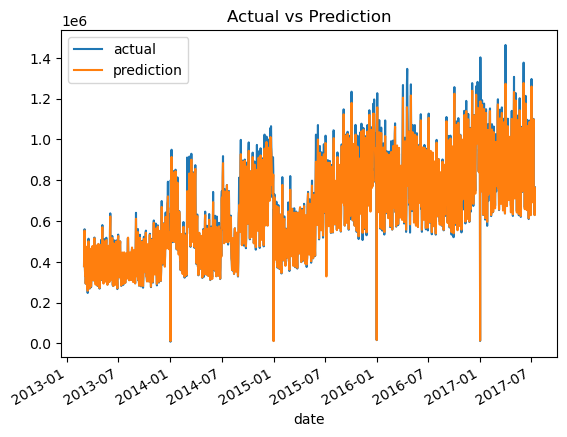

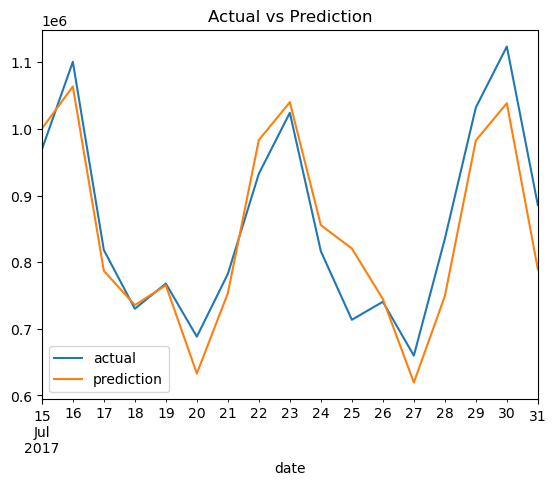

In [36]:
print('===> Print All stores Training Prediction')
training_total_pred_df = training_total_pred_df.sort_values(['date', 'store_nbr', 'family'])
training_score = mean_squared_log_error(train_df['sales'].values, training_total_pred_df['sales'].values, squared=False)
plot_predition_timeseries(x=training_total_pred_df.index.get_level_values('date'),
                            y_actual=train_df['sales'].values,
                            y_pred=training_total_pred_df['sales'].values)

print('===> Print All stores Test Prediction')
test_total_pred_df = test_total_pred_df.sort_values(['date', 'store_nbr', 'family'])
test_score = mean_squared_log_error(test_df['sales'].values, test_total_pred_df['sales'].values, squared=False)
plot_predition_timeseries(x=test_total_pred_df.index.get_level_values('date'),
                            y_actual=test_df['sales'].values,
                            y_pred=test_total_pred_df['sales'].values)

print(f'RMSLE || TRAINING Score: {training_score} | TEST Score: {test_score}')

In [37]:
%%time
train_df, test_df = index_timeseries_train_test_split(df=df,
                                                      date_index='date',
                                                      date_format='%Y-%m-%d',
                                                      earliest_train_date='2013-03-01',
                                                      split_date='2017-08-16',
                                                      verbose=False)

# Get stopped families for each store
closed_stores_df = get_closed_stores(train_df, last_days=12)


training_total_pred_df = pd.DataFrame()
test_total_pred_df = pd.DataFrame()
for train_pred_df, test_pred_df in family_prediction_generator(train_df, test_df):
    # Keep prediction for submission
    training_total_pred_df = pd.concat([training_total_pred_df, train_pred_df])
    test_total_pred_df = pd.concat([test_total_pred_df, test_pred_df])

  0%|          | 0/33 [00:00<?, ?it/s]

Family: AUTOMOTIVE
RMSLE || TRAINING Score: 0.21202585582978825
Family: BABY CARE
RMSLE || TRAINING Score: 0.07745205994056881
Family: BEAUTY
RMSLE || TRAINING Score: 0.18934853751716593
Family: BEVERAGES
RMSLE || TRAINING Score: 0.1017349340468685
Family: BOOKS
RMSLE || TRAINING Score: 0.050721384413522815
Family: BREAD/BAKERY
RMSLE || TRAINING Score: 0.08292291375534319
Family: CELEBRATION
RMSLE || TRAINING Score: 0.17719559297870777
Family: CLEANING


Column name,Status,Description
date,All valid,All values in this column are good to go
target,All valid,All values in this column are good to go
country_iso_code,All valid,All values in this column are good to go


Running search request with search_id=e10fd050-bf57-4dd4-bfce-73107179ff4c
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com
Done


8 relevant feature(s) found with the search keys: ['date', 'country_iso_code']


provider,source,feature name,shap value,coverage %,type,feature type
Upgini,Public/Comm. shared,f_events_date_week_sin1_847b5db1,0.355322,100.000000,numerical,Free
Upgini,Public/Comm. shared,f_events_date_month_cos1_175991a9,0.128888,100.000000,numerical,Free
Upgini,Public/Comm. shared,f_events_country_date_holiday_code_9a141884,0.127730,100.000000,numerical,Free
Upgini,Public/Comm. shared,f_financial_date_gold_3295eb6b,0.035604,100.000000,numerical,Free
Upgini,Public/Comm. shared,f_events_country_date_days_from_holiday_93c12a82,0.031605,100.000000,numerical,Free
Upgini,Public/Comm. shared,f_events_date_month_sin2_75888cbd,0.030011,100.000000,numerical,Free
Upgini,Public/Comm. shared,f_events_date_month_sin1_51d9011f,0.025885,100.000000,numerical,Free
Upgini,Public/Comm. shared,f_financial_date_crude_oil_a27b1766,0.024972,100.000000,numerical,Free


Calculating metrics...
Done

Quality metrics


,match_rate,enriched mean_squared_error
,,
train,100.0,54564.03321


Column name,Status,Description
country_iso_code,All valid,All values in this column are good to go
date,All valid,All values in this column are good to go


Running search request with search_id=00b74e4d-1e53-4731-bf76-aa841554f74e
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com
Done

Done


Column name,Status,Description
country_iso_code,All valid,All values in this column are good to go
date,All valid,All values in this column are good to go


Running search request with search_id=a2b7656f-d992-4f0d-bbb1-f119de8fd035
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com
Done

Done
RMSLE || TRAINING Score: 0.08859039103400318
Family: DAIRY
RMSLE || TRAINING Score: 0.08585798914696992
Family: DELI
RMSLE || TRAINING Score: 0.08379938154847931
Family: EGGS
RMSLE || TRAINING Score: 0.1222460795198693
Family: FROZEN FOODS
RMSLE || TRAINING Score: 0.13347147904275833
Family: GROCERY I
RMSLE || TRAINING Score: 0.09560993004276773
Family: GROCERY II
RMSLE || TRAINING Score: 0.21529652987934478
Family: HARDWARE
RMSLE || TRAINING Score: 0.2046084122891679
Family: HOME AND KITCHEN I
RMSLE || TRAINING Score: 0.21232441896708792
Family: HOME AND KITCHEN II
RMSLE || TRAINING Score: 0.16740414415891475
Family: HOME APPLIANCES
RMSLE || TRAINING Score: 0.14317155056266337
Family: HOME CARE
RMSLE || TRAINING Score: 0.11707863717395997
Family: LADIESWEAR
RMSLE || TRAINING Score: 0.147281254773

Column name,Status,Description
date,All valid,All values in this column are good to go
target,All valid,All values in this column are good to go
country_iso_code,All valid,All values in this column are good to go


Running search request with search_id=194a6e90-64a6-490e-bd7f-ef6f5224fd13
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com
Done


6 relevant feature(s) found with the search keys: ['date', 'country_iso_code']


provider,source,feature name,shap value,coverage %,type,feature type
Upgini,Public/Comm. shared,f_events_country_date_holiday_code_3d_ahead_2015c9e5,0.730089,100.000000,numerical,Free
Upgini,Public/Comm. shared,f_events_date_year_cos1_9014a856,0.026557,100.000000,numerical,Free
Upgini,Public/Comm. shared,f_events_date_week_sin2_e28440a5,0.023827,100.000000,numerical,Free
Upgini,Public/Comm. shared,f_events_country_date_month_86063673,0.022697,100.000000,numerical,Free
Upgini,Public/Comm. shared,f_economic_country_date_capital_goods_industrial_f4bb6132,0.017218,100.000000,numerical,Free
Upgini,Public/Comm. shared,f_weather_date_weather_pca_1_9e4af931,0.012237,100.000000,numerical,Free


Calculating metrics...
Done

Quality metrics


,match_rate,enriched mean_squared_error
,,
train,100.0,1719.328004


Column name,Status,Description
country_iso_code,All valid,All values in this column are good to go
date,All valid,All values in this column are good to go


Running search request with search_id=b61d688a-58bc-4980-9fa3-813286cd9d15
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com
Done

Done


Column name,Status,Description
country_iso_code,All valid,All values in this column are good to go
date,All valid,All values in this column are good to go


Running search request with search_id=27ff9b0a-67e7-4b15-ab1f-13dea74227c0
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com
Done

Done
RMSLE || TRAINING Score: 0.269015134190145
Family: MAGAZINES
RMSLE || TRAINING Score: 0.1599303227472418
Family: MEATS
RMSLE || TRAINING Score: 0.09844268469608371
Family: PERSONAL CARE
RMSLE || TRAINING Score: 0.09957895143598058
Family: PET SUPPLIES
RMSLE || TRAINING Score: 0.1505400909115592
Family: PLAYERS AND ELECTRONICS
RMSLE || TRAINING Score: 0.15980190644079956
Family: POULTRY
RMSLE || TRAINING Score: 0.10209128521877223
Family: PREPARED FOODS
RMSLE || TRAINING Score: 0.11641951412381582
Family: PRODUCE
RMSLE || TRAINING Score: 0.1613144729860852
Family: SCHOOL AND OFFICE SUPPLIES
RMSLE || TRAINING Score: 0.1426648228437163
Family: SEAFOOD
RMSLE || TRAINING Score: 0.18477269950805883
CPU times: user 52min 57s, sys: 4min 34s, total: 57min 31s
Wall time: 2h 31min 55s


In [38]:
test_total_pred_df = test_total_pred_df.sort_values(['date', 'store_nbr', 'family'])

# Zero the sales for stopped families
test_total_pred_df= apply_zero_forecasting(test_total_pred_df, closed_stores_df)

ids = pd.read_csv(path + 'test.csv')['id']
test_total_pred_df['id'] = ids.values

submit_df = test_total_pred_df[['id', 'sales']]

if len(submit_df) != 28512: # Minor check before submission :-)
    raise Exception(f'The rows ({len(submit_df)}) of the export are not correct')
else:
    current_dateTime = datetime.now()
    latest_filename = 'submission.csv'
    submit_df.to_csv(latest_filename, index=True)


In [39]:
resub = pd.read_csv(latest_filename)
resub.drop(['date', 'store_nbr', 'family'], axis=1, inplace=True)
resub.set_index('id', inplace=True)
resub.to_csv('submission_clean_multi_redux.csv', index=True)